In [1]:
import os
import csv
import cv2
import numpy as np


samples = []
with open('../Data/train_sim2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    index = 0
    for line in reader:
        if index % 6 == 0:
            samples.append(line)
        index += 1


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

train_samples, validation_samples = train_test_split(samples, test_size=0.2)


In [3]:
import sklearn
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Convolution2D, MaxPooling2D, Dropout

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []
            steering_angles = []
            car_images_flipped = []
            steering_angles_flipped = []

            for batch_sample in batch_samples:
                steering_center = float(batch_sample[3])

                correction = 0.2  # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction

                # read in images from center, left and right cameras
                path = ''  # fill in the path to your training IMG directory
                img_center = ((cv2.imread(path + batch_sample[0])))
                img_left = ((cv2.imread(path + batch_sample[1])))
                img_right = ((cv2.imread(path + batch_sample[2])))

                # add images and angles to data set
                car_images.extend([img_center, img_left, img_right])
                steering_angles.extend([steering_center, steering_left, steering_right])

                car_images_flipped.extend([cv2.flip(img_center, 1), cv2.flip(img_left, 1),
                                           cv2.flip(img_right, 1)])
                steering_angles_flipped.extend([-steering_center, -steering_left, -steering_right])


            # trim image to only see section with road
            X_train = np.concatenate((np.array(car_images), np.array(car_images_flipped)))
            y_train = np.concatenate((np.array(steering_angles), np.array(steering_angles_flipped)))

            yield sklearn.utils.shuffle(X_train, y_train)


Using TensorFlow backend.


In [4]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

ch, row, col = 3, 80, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation
model.add(Lambda(lambda x: x/255 -0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((75,20),(0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(64,3,3, subsample=(1,1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(64,3,3, subsample=(1,1), activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dense(1))

Epoch 1/5
7704/7704 [==============================] - 71s - loss: 0.0405 - val_loss: 0.0304
Epoch 2/5
7704/7704 [==============================] - 72s - loss: 0.0295 - val_loss: 0.0276
Epoch 3/5
7704/7704 [==============================] - 73s - loss: 0.0278 - val_loss: 0.0261
Epoch 4/5
7704/7704 [==============================] - 73s - loss: 0.0271 - val_loss: 0.0259
Epoch 5/5
7704/7704 [==============================] - 76s - loss: 0.0265 - val_loss: 0.0255
Model saved.
dict_keys(['loss', 'val_loss'])


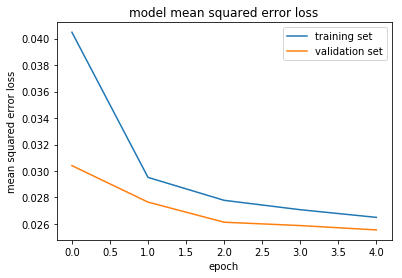

In [5]:
import matplotlib.pyplot as plt


model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= \
            len(train_samples)*6, validation_data=validation_generator, \
            nb_val_samples=len(validation_samples)*6, nb_epoch=5, verbose = 1)

model.save('model_deep_cnn_dropout_generator_sim2.h5')
print('Model saved.')

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()